**Download the dataset**

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset")


Skipping, found downloaded files in "./plant-disease-recognition-dataset" (use force=True to force download)


**Importing Required Libraries**

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from PIL import Image
import IPython.display as display
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

**Defining Dataset Directories**

In [ ]:


# Function to count files in a directory
def count_files_in_directory(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

# Directories for train, validation, and test datasets
train_dir = '/content/plant-disease-recognition-dataset/Train/Train'
val_dir = '/content/plant-disease-recognition-dataset/Validation/Validation'
test_dir = '/content/plant-disease-recognition-dataset/Test/Test'

# Count files in each directory
train_files = count_files_in_directory(train_dir)
val_files = count_files_in_directory(val_dir)
test_files = count_files_in_directory(test_dir)

# Display the counts
print(f"Total training images: {train_files}")
print(f"Total validation images: {val_files}")
print(f"Total test images: {test_files}")

Total training images: 1322
Total validation images: 60
Total test images: 150


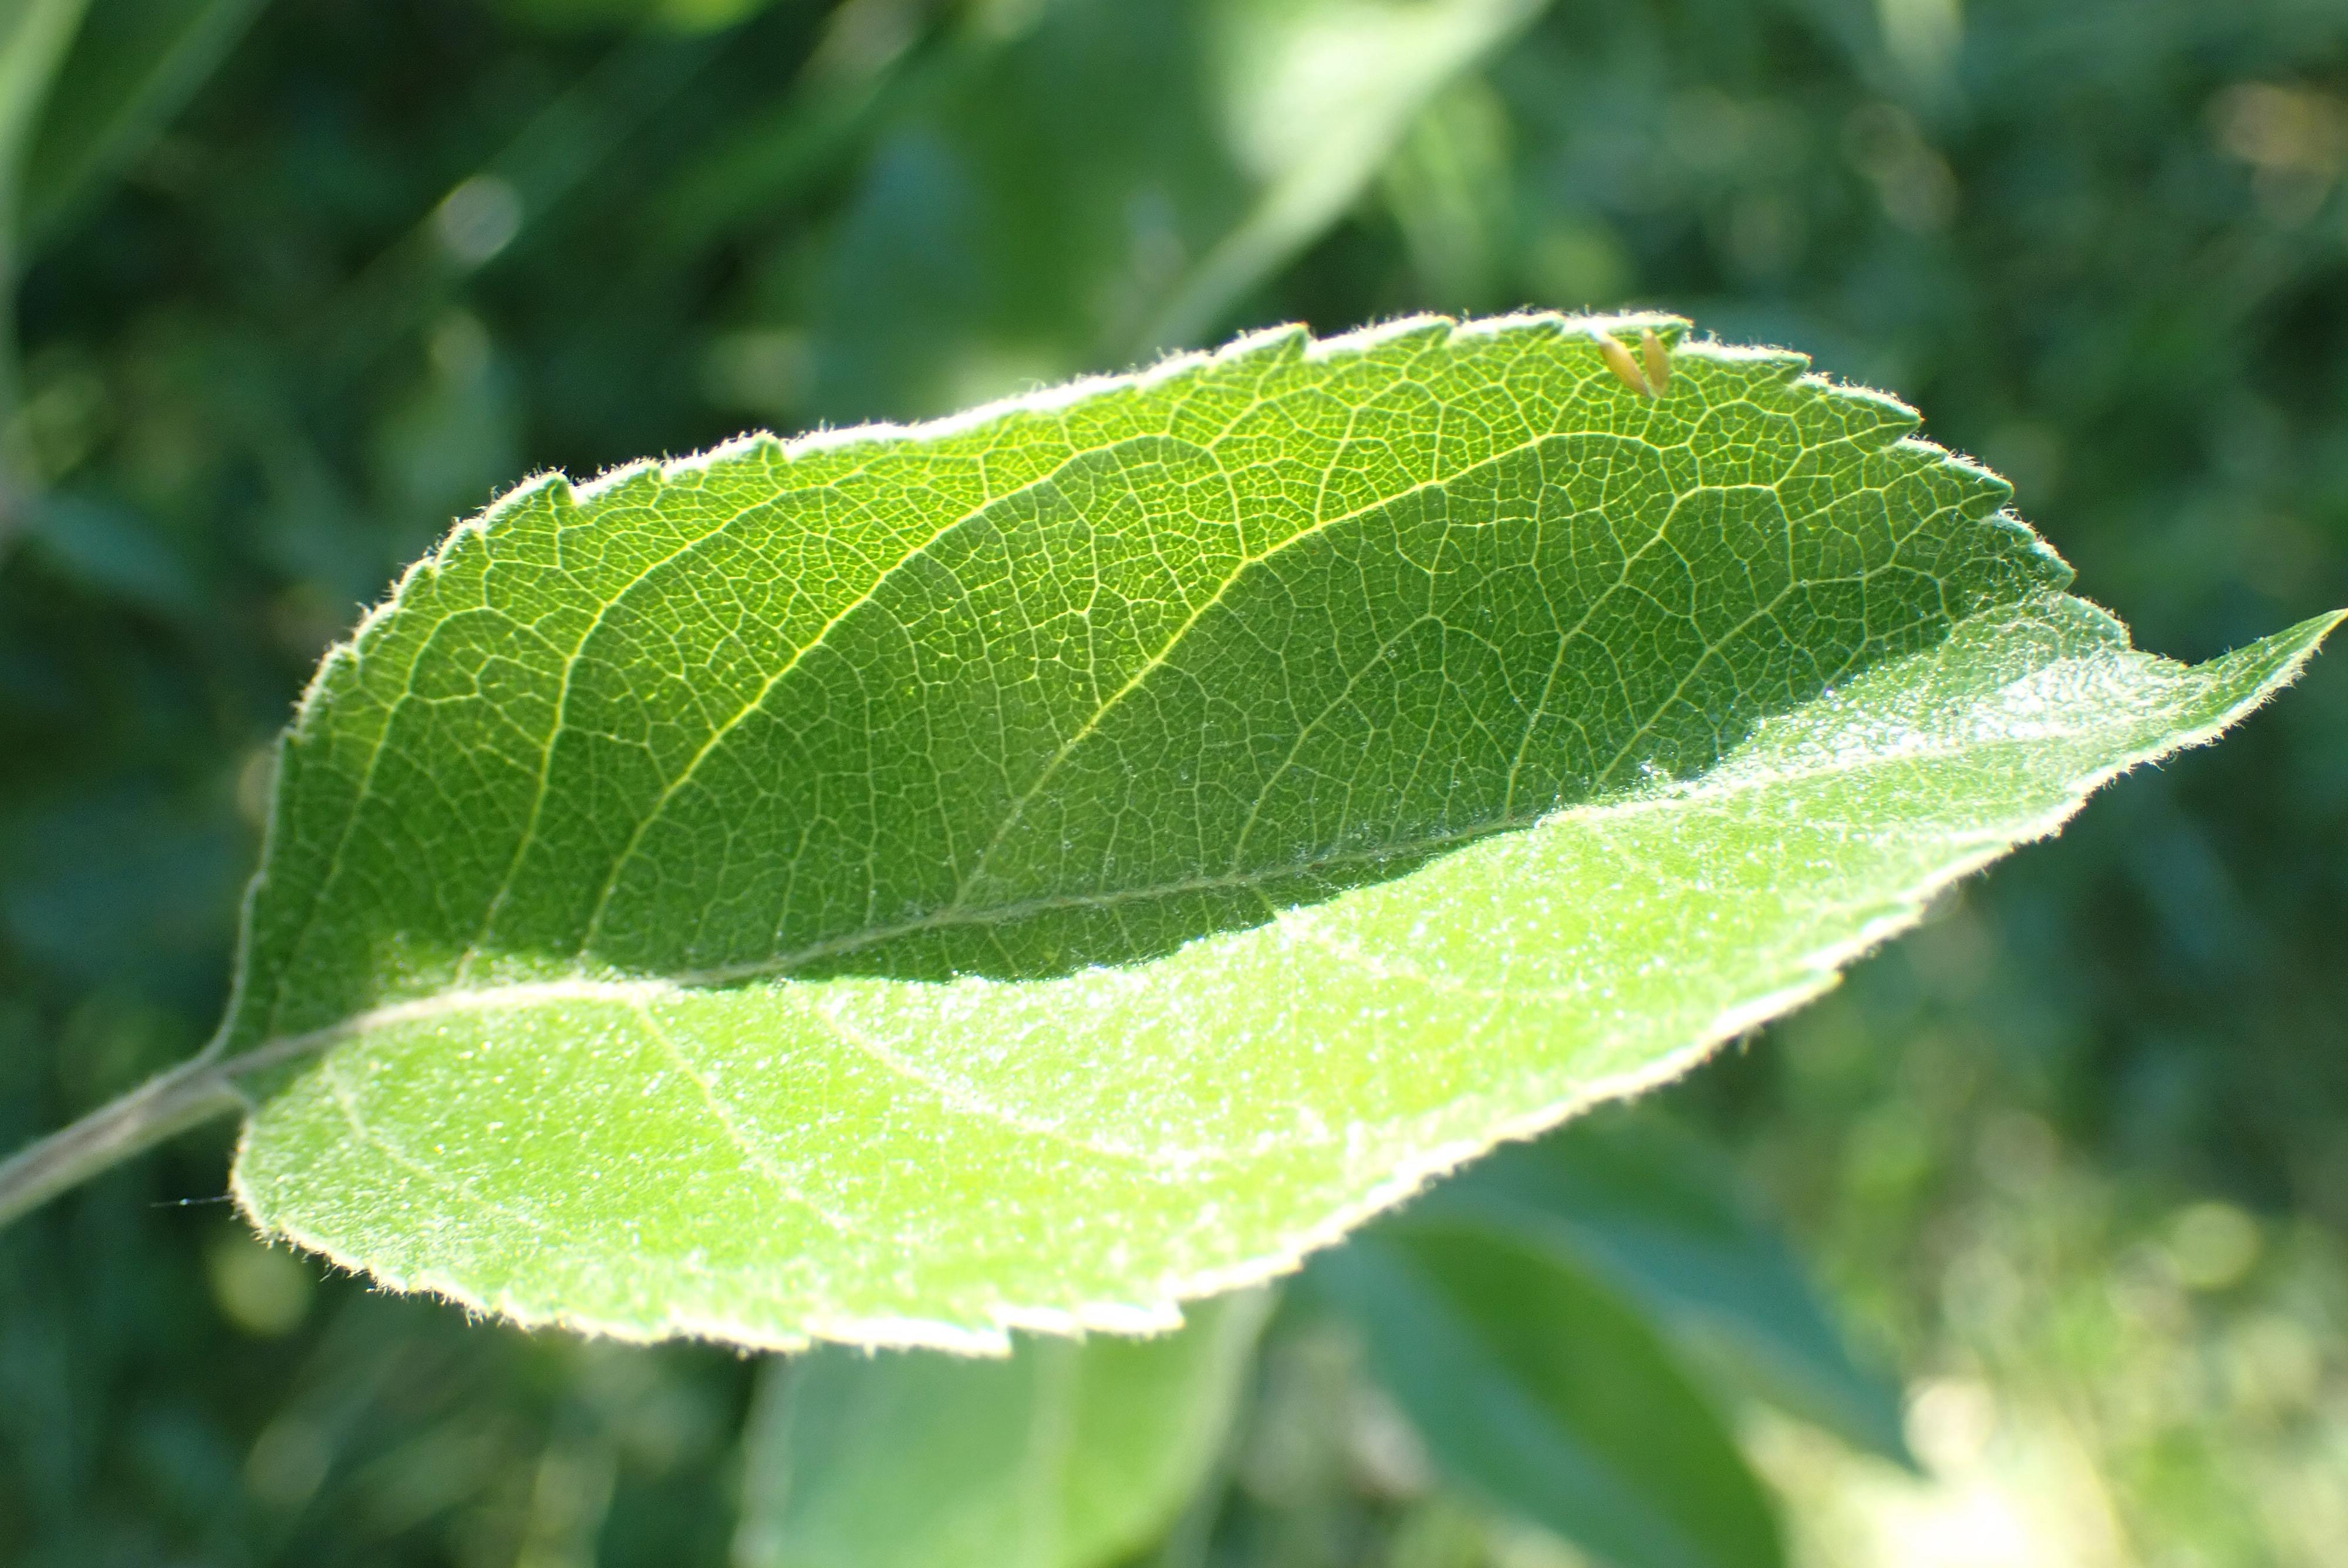

In [ ]:
image_path = '/content/plant-disease-recognition-dataset/Train/Train/Healthy/811b2bd335e9cb16.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

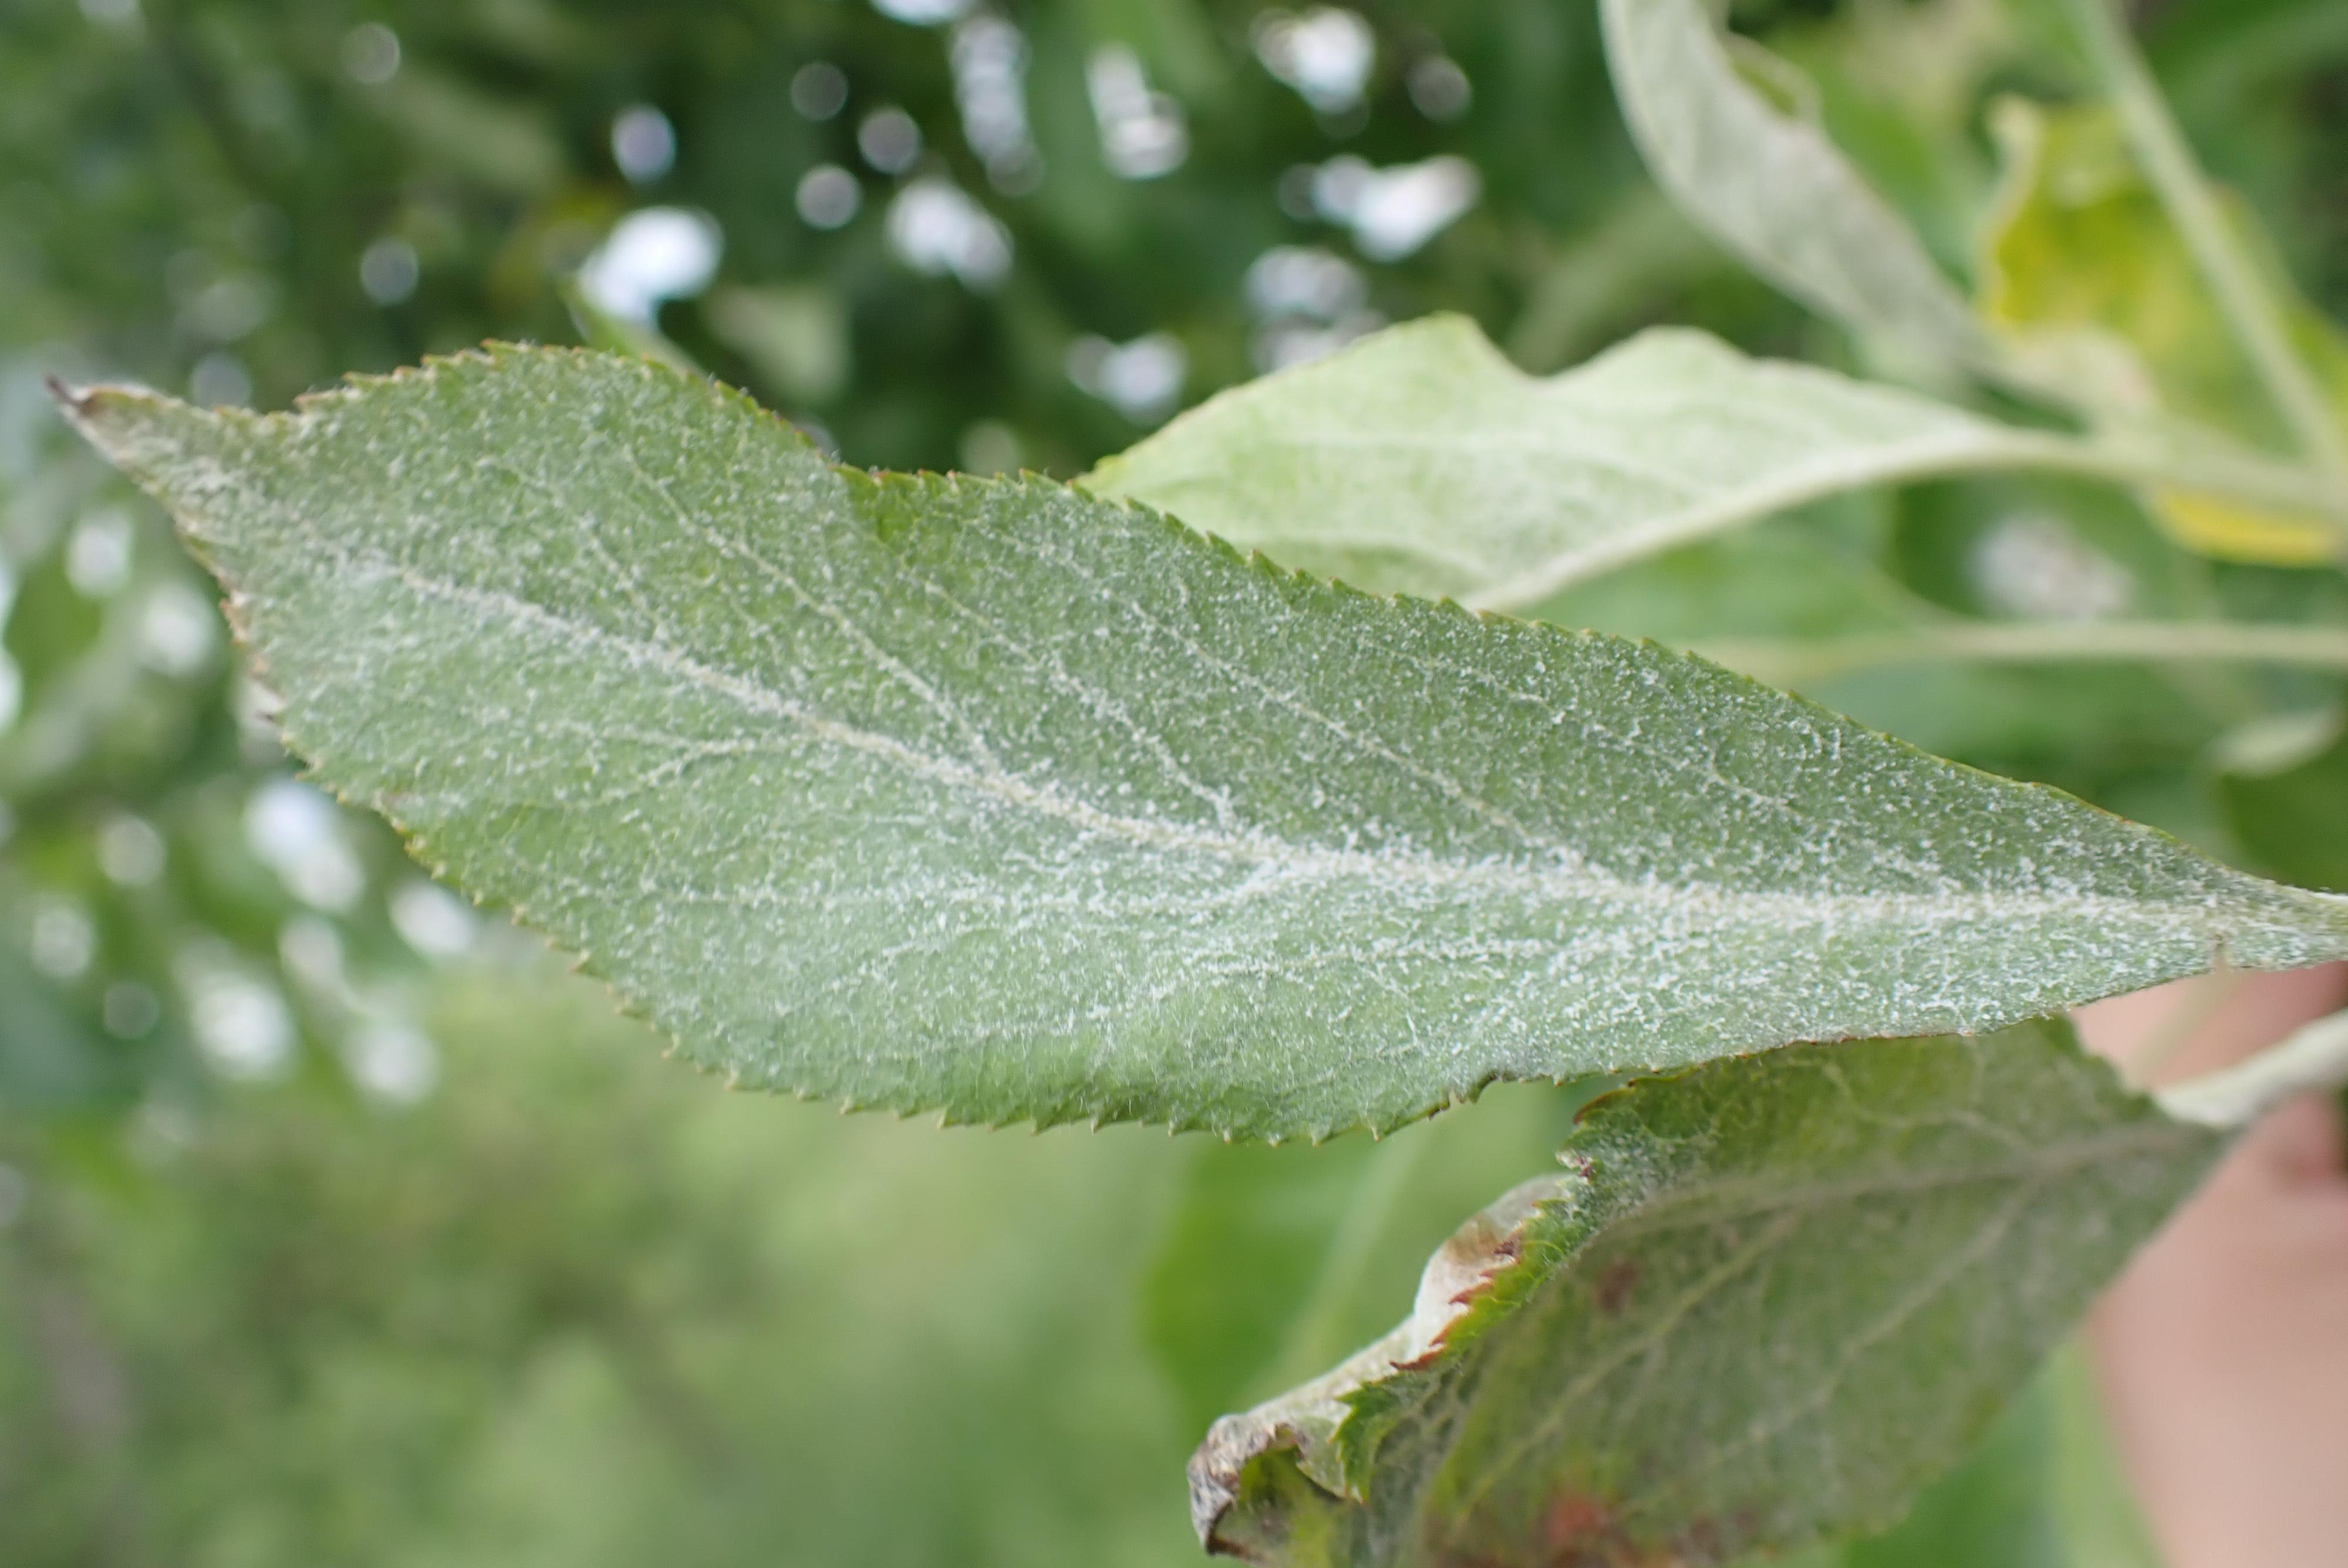

In [ ]:
image_path = '/content/plant-disease-recognition-dataset/Train/Train/Powdery/81352f0c4c5efa9b.jpg'
with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

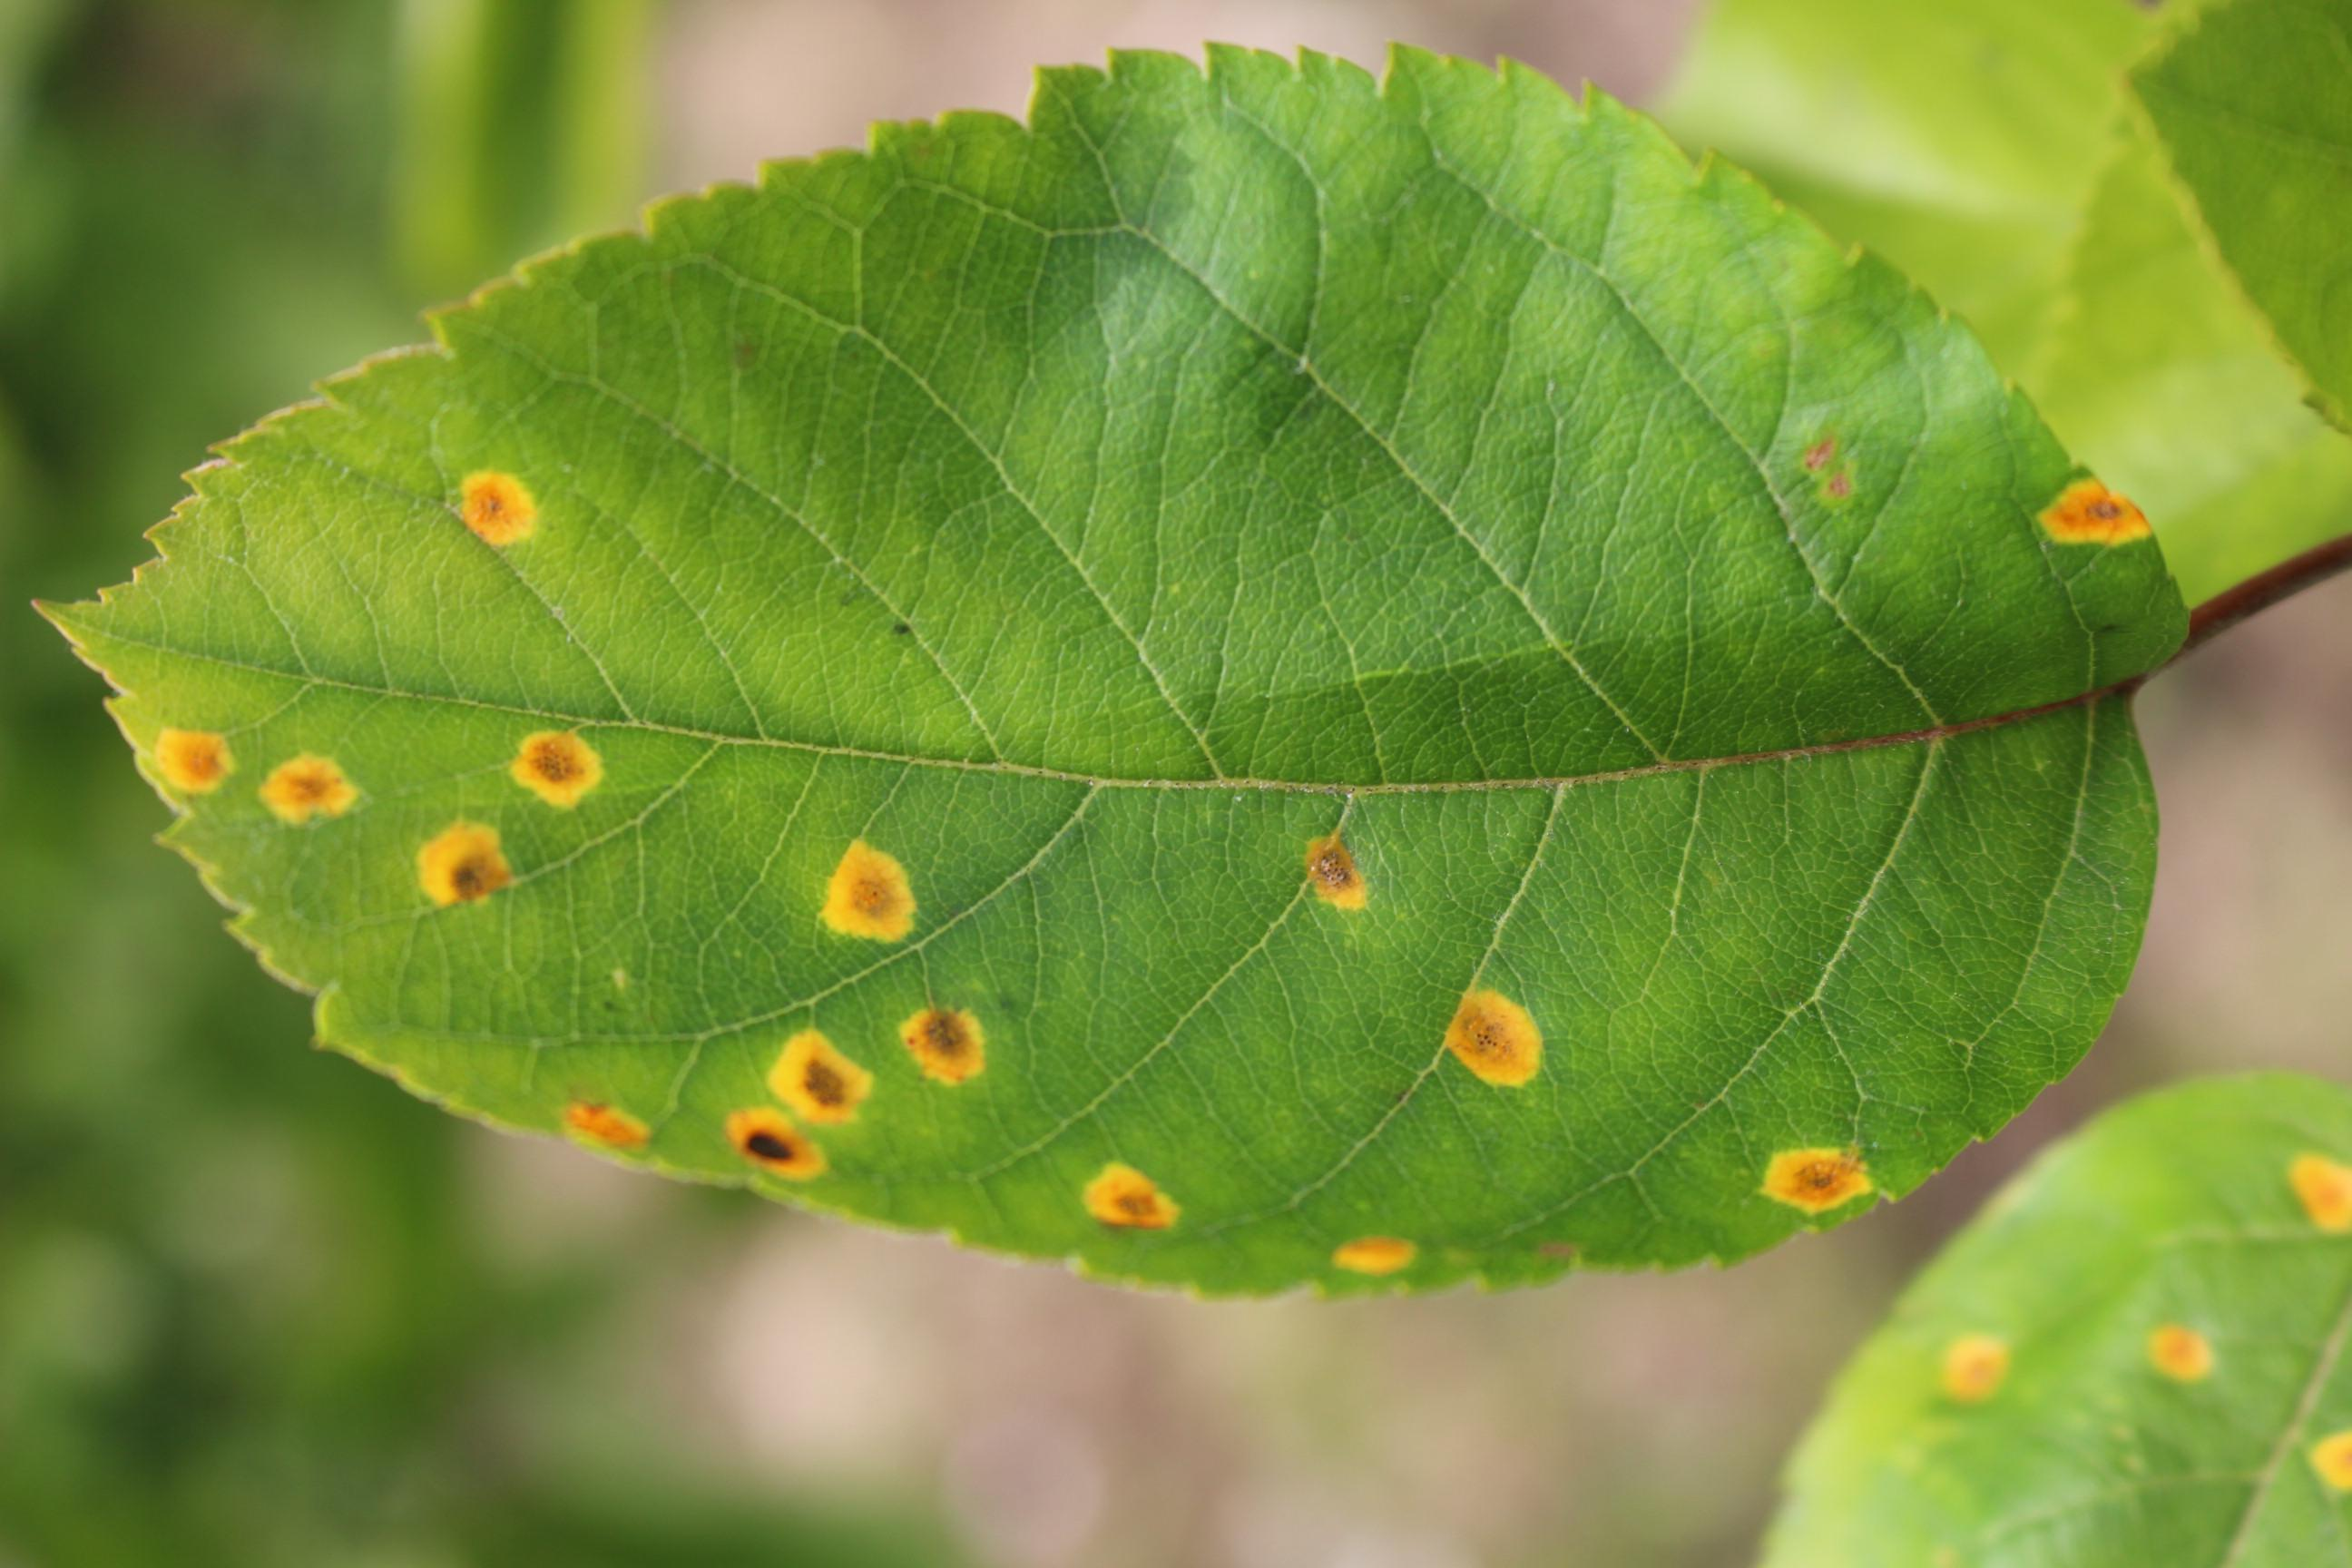

In [ ]:
image_path = '/content/plant-disease-recognition-dataset/Train/Train/Rust/80f09587dfc7988e.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

In [ ]:

# Directory with class folders (e.g., 'train')
data_dir = '/content/plant-disease-recognition-dataset/Train/Train'

# Count images per class
class_names = []
image_counts = []

for class_folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        class_names.append(class_folder)
        image_counts.append(count)

# Plot
fig = px.bar(x=class_names, y=image_counts, labels={'x': 'Class', 'y': 'Image Count'},
             title='Image Count per Class')
fig.show()

**Data Preprocessing & Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(225, 225), batch_size=32, class_mode='categorical')

validation_generator = test_val_datagen.flow_from_directory(
    val_dir, target_size=(225, 225), batch_size=32, class_mode='categorical')

test_generator = test_val_datagen.flow_from_directory(
    test_dir, target_size=(225, 225), batch_size=32, class_mode='categorical', shuffle=False)


Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(225, 225, 3))
base_model.trainable = False  # Freeze convolutional base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


<ipython-input-10-4b36cb155159>:1: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 225, 225,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 113, 113,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 113, 113,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 113, 113,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 113, 113,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 113, 113,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 113, 113,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 113, 113,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 113, 113,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 115, 115,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 57, 57,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 57, 57,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 57, 57,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 57, 57,    │      2,304 │ block_1_depthwis

 Total params: 2,340,163 (8.93 MB)

 Trainable params: 82,179 (321.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Training the Model**


In [ ]:
history = model.fit(
    train_generator,batch_size=16,
    epochs=5,
    validation_data=validation_generator,
    validation_batch_size=16)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.5985 - loss: 0.9103 - val_accuracy: 0.9333 - val_loss: 0.2149
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8766 - loss: 0.3423 - val_accuracy: 0.9500 - val_loss: 0.1431
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9337 - loss: 0.2030 - val_accuracy: 0.9667 - val_loss: 0.1212
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9401 - loss: 0.1727 - val_accuracy: 0.9667 - val_loss: 0.1608
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9276 - loss: 0.2017 - val_accuracy: 0.9333 - val_loss: 0.1285


In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9347 - loss: 0.1343
Validation Accuracy: 93.33%
Validation Loss: 0.1285


In [ ]:
import pickle

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
model.save("plant-disease.h5")
model.save("plant-disease.keras")

In [ ]:

# Set dark theme
pio.templates.default = "plotly_dark"

# Example data (replace with your own)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = go.Figure([
    go.Scatter(y=accuracy, name='Train'),
    go.Scatter(y=val_accuracy, name='Val')
])

fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy'
)

fig.show()

In [ ]:
# Set dark theme
pio.templates.default = "plotly_dark"

# Example data (replace with your own)
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = go.Figure([
    go.Scatter(y=loss, name='Train'),
    go.Scatter(y=val_loss, name='Val')
])

fig.update_layout(
    title='Model Loss',
    xaxis_title='Epoch',
    yaxis_title='Loss'
)

fig.show()

In [ ]:

# Assuming your model is already loaded and test_generator is defined
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

def predict_image_from_path(img_path):
    img = image.load_img(img_path, target_size=(225, 225))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension
    img_array /= 255.0  # normalize

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    confidence = np.max(prediction)
    predicted_label = index_to_class[predicted_index]

    return predicted_label, confidence


In [ ]:


# Assuming you already have these variables from your model and test_generator
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Define the function to display image and predict label with confidence
def predict_image_from_path(img_path):
    # Load and display the image
    img = image.load_img(img_path, target_size=(225, 225))

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axis for cleaner view
    plt.show()

    # Preprocess the image for prediction
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array /= 255.0  # normalize

    # Predict the class and confidence
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    confidence = np.max(prediction)
    predicted_label = index_to_class[predicted_index]

    return predicted_label, confidence



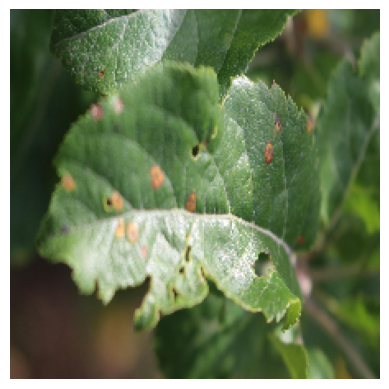

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: Rust with confidence: 1.00


In [ ]:
# Now you can call this function with an image path
img_path = '/content/plant-disease-recognition-dataset/Test/Test/Rust/830f26cc6d3cd13e.jpg'  # change this to your image path
label, confidence = predict_image_from_path(img_path)

# Print the result
print(f"Predicted: {label} with confidence: {confidence:.2f}")

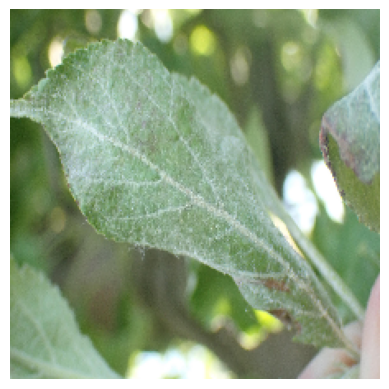

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted: Powdery with confidence: 0.88


In [ ]:
# Now you can call this function with an image path
img_path = '/content/plant-disease-recognition-dataset/Test/Test/Powdery/81c36e378473c93e.jpg'  # change this to your image path
label, confidence = predict_image_from_path(img_path)

# Print the result
print(f"Predicted: {label} with confidence: {confidence:.2f}")

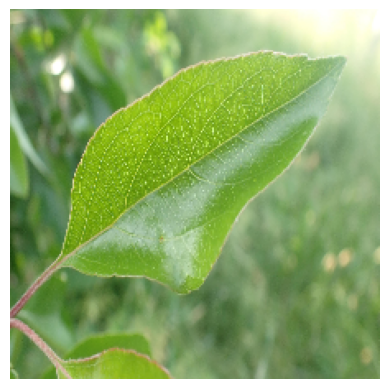

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted: Healthy with confidence: 0.90


In [ ]:
# Now you can call this function with an image path
img_path = '/content/plant-disease-recognition-dataset/Test/Test/Healthy/8eb3b68893378387.jpg'  # change this to your image path
label, confidence = predict_image_from_path(img_path)

# Print the result
print(f"Predicted: {label} with confidence: {confidence:.2f}")

In [ ]:
# Predict on test data
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)  # predicted class indices
y_true = test_generator.classes          # actual class indices


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [ ]:
class_labels = list(test_generator.class_indices.keys())


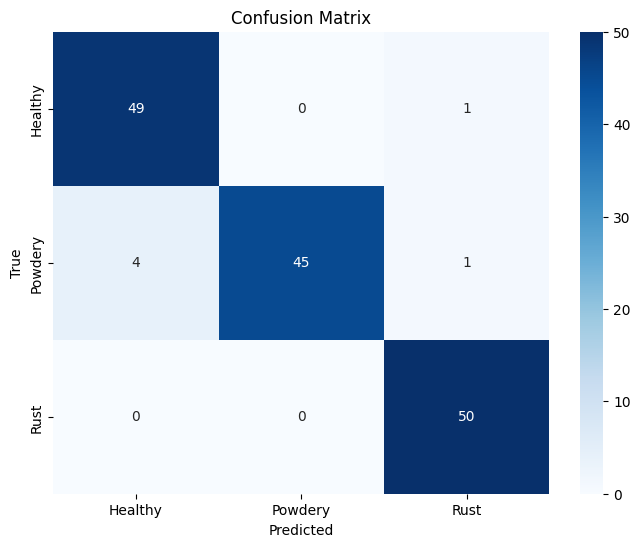

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.92      0.98      0.95        50
     Powdery       1.00      0.90      0.95        50
        Rust       0.96      1.00      0.98        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)
